In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import mapie
import sklearn
assert sklearn.__version__ >= "0.20"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
np.random.seed(47)

length = 10000
df = pd.DataFrame(np.random.rand(length, 6), columns=['f1','f2','f3','f4','f5','target'])
df['target'] = df['target']*100

In [4]:
train = df[:8000]
test = df[8000:]

In [5]:
X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

RF = RandomForestRegressor()
RF.fit(X_train, y_train)
rf_train_pred = RF.predict(X_train)

rf_train_rmse = mean_squared_error(y_train, rf_train_pred, squared=False)
print('RMSE Score: %.2f' %rf_train_rmse)

RMSE Score: 11.10


In [7]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

XGB = XGBRegressor()
XGB.fit(X_train, y_train)
xgb_train_pred = XGB.predict(X_train)

xgb_train_rmse = mean_squared_error(y_train, xgb_train_pred, squared=False)
print('RMSE Score: %.2f' %xgb_train_rmse)

RMSE Score: 19.93


In [8]:
from sklearn.model_selection import cross_val_score

rf_scores = cross_val_score(RF, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)

print("Scores: ", rf_rmse_scores)
print("Mean: %.2f" %rf_rmse_scores.mean())
print("Standard deviation: %.2f" %rf_rmse_scores.std())

Scores:  [29.0736197  30.54989616 29.93548926 29.22848854 29.80426922 29.76740863
 29.15669227 30.05364428 29.67999832 28.92767545]
Mean: 29.62
Standard deviation: 0.49


In [9]:
xgb_scores = cross_val_score(XGB, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)

print("Scores: ", xgb_rmse_scores)
print("Mean: %.2f" %xgb_rmse_scores.mean())
print("Standard deviation: %.2f" %xgb_rmse_scores.std())

Scores:  [30.35735398 31.47723526 30.5437656  30.03194094 31.11296312 30.39815345
 30.13243531 30.59489641 30.00137346 29.91943386]
Mean: 30.46
Standard deviation: 0.48


In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    #try 12 (3*4)combinations of hyperparameters
    {'n_estimators': [3,10,30], 
     'max_features': [2,4,6,8],
     'random_state': [47]}
]

RF = RandomForestRegressor()

grid_search = GridSearchCV(RF, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30], 'random_state': [47]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [11]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30, 'random_state': 47}

In [12]:
from interval_regressor import IntervalRegressor

RF= RandomForestRegressor
params = grid_search.best_params_

model = IntervalRegressor(output='mid', base_estimator=RF, base_estimator_params=params)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

In [13]:
rf_interval_rmse = mean_squared_error(y_train, y_pred, squared=False)
print('RMSE Score: %.2f' %rf_interval_rmse)

RMSE Score: 11.62


In [14]:
clf = IntervalRegressor(output='lower', mapie_alpha=0.1, base_estimator=RF, base_estimator_params=params)
clf.fit(X_train, y_train)
lower_preds = clf.predict(X_test)

clf = IntervalRegressor(output='upper', mapie_alpha=0.1, base_estimator=RF, base_estimator_params=params)
clf.fit(X_train, y_train)
upper_preds = clf.predict(X_test)

clf = IntervalRegressor(output='mid', mapie_alpha=0.1, base_estimator=RF, base_estimator_params=params)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

interval_preds = pd.DataFrame({
    'actual': y_test,
    'lower': lower_preds,
    'upper': upper_preds,
    'predictions': preds
}, index=y_test.index)

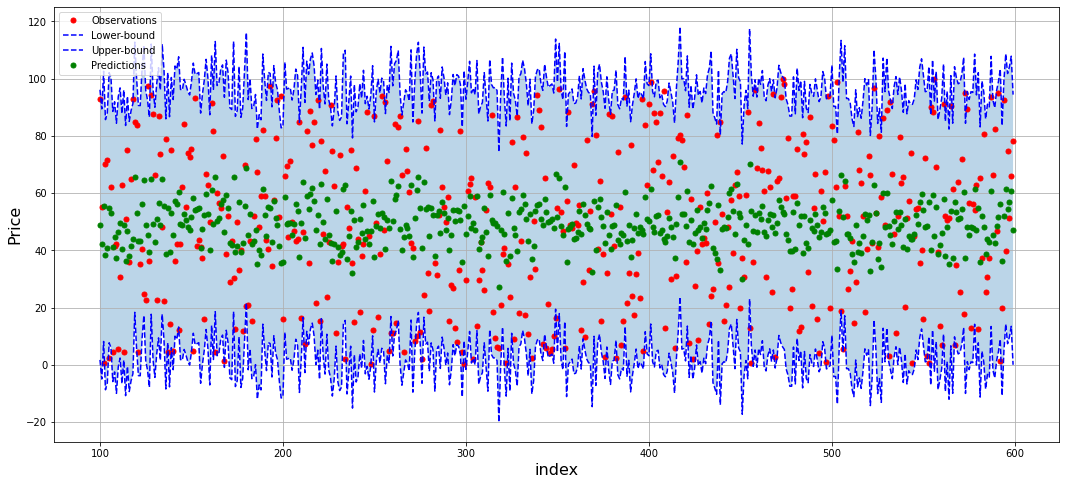

In [15]:
from interval_regressor import plot_interval_regression

plot_interval_regression(data=interval_preds,
                         y_label='Price',
                         start_index=100,
                         step_index=500,
                         prediction=True)

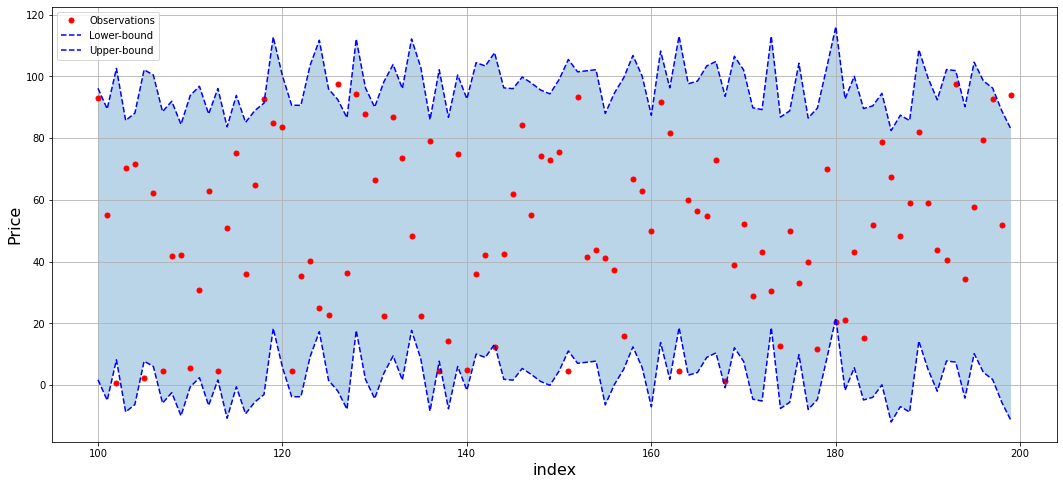

In [17]:
plot_interval_regression(data=interval_preds,
                         y_label='Price',
                         start_index=100,
                         step_index=100,
                         prediction=False)